In [1]:
from esda.moran import Moran
import geopandas as gpd
from libpysal.weights import DistanceBand, KNN
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd
from splot.esda import plot_moran
import statsmodels.api as sm
import sys
%matplotlib inline

sys.path.append("..")
from statshelper import q_q_plot, stepwise_model_selection
plt.style.use('dark_background')

In [2]:
df = pd.read_pickle("../data/processed/Cleaned_Chicago_Sales.pkl")
print("Data frame has {} rows and {} columns".format(len(df), len(df.columns)))
drop_these = []
for col in df.columns:
    if col[:4] == "Bool":
        drop_these.append(col)
df = df.drop(drop_these, axis=1)
print(list(df.columns))
df.head()

Data frame has 324261 rows and 131 columns
['PIN', 'Property Class', 'Neighborhood Code', 'Land Square Feet', 'Town Code', 'Type of Residence', 'Apartments', 'Wall Material', 'Roof Material', 'Rooms', 'Bedrooms', 'Basement', 'Basement Finish', 'Central Heating', 'Central Air', 'Fireplaces', 'Attic Type', 'Attic Finish', 'Half Baths', 'Design Plan', 'Cathedral Ceiling', 'Site Desirability', 'Garage 1 Size', 'Garage 1 Material', 'Garage 1 Attachment', 'Garage 1 Area', 'Garage 2 Size', 'Garage 2 Material', 'Garage 2 Attachment', 'Garage 2 Area', 'Porch', 'Building Square Feet', 'Estimate (Land)', 'Estimate (Building)', 'Sale Date', 'Deed No.', 'Sale Price', 'Longitude', 'Latitude', 'Census Tract', 'Multi Property Indicator', 'Full Baths', 'Age', 'Use', "O'Hare Noise", 'Floodplain', 'Road Proximity', 'Sale Year', 'Sale Quarter', 'Sale Half-Year', 'Sale Quarter of Year', 'Sale Half of Year', 'Age Squared', 'Age Decade Squared', 'Pure Market Filter', 'Garage Indicator', 'Square root of lot s

,PIN,Property Class,Neighborhood Code,Land Square Feet,Town Code,Type of Residence,Apartments,Wall Material,Roof Material,Rooms,...,Sale Quarter,Sale Half-Year,Sale Quarter of Year,Sale Half of Year,Age Squared,Age Decade Squared,Pure Market Filter,Garage Indicator,Square root of lot size,Town and Neighborhood
2,16094150130000,211,13,-0.297580,77,3.0,6.0,2.0,2.0,3.737790,...,-0.857915,36,4,2,7569,75.690002,1,1.0,67.082039,7713
5,4252000820000,204,100,2.868180,25,5.0,0.0,2.0,4.0,1.482994,...,-0.983113,36,3,2,3721,37.209999,1,1.0,184.114090,25100
8,14322110150000,208,12,-0.596010,74,3.0,0.0,2.0,6.0,0.903020,...,0.769658,43,1,1,16,0.160000,1,1.0,60.991802,7412
9,27021200080000,204,34,1.698873,28,1.0,0.0,3.0,1.0,0.176677,...,-0.106728,39,2,1,841,8.410000,1,1.0,126.802994,2834
11,13121080620000,204,42,0.515768,71,1.0,0.0,2.0,1.0,-0.268846,...,-0.983113,36,3,2,3844,38.439999,1,1.0,86.948257,7142


In [3]:
i_vars = [
    'Age',
    'Bedrooms',  
    'Building Square Feet', 
    'Estimate (Building)', 
    'Estimate (Land)', 
    'Fireplaces', 
    'Full Baths',
    'Garage 1 Area',
    'Garage 2 Area', 
    'Half Baths', 
    'Land Square Feet',
    'Latitude',
    'Longitude',
    'Rooms',
    'Sale Quarter'
    ]
dep_var = ['Sale Price']
X = df[i_vars]
y = df[dep_var]

In [4]:
stepwise_model_selection(dep_var, i_vars, df)


Current model: ['Sale Price'] ~ intercept
        current   920213.86
+           Age   910962.35
+      Bedrooms   893870.99
+  Building Square Feet   839781.69
+  Estimate (Building)   641158.68
+  Estimate (Land)   743130.44
+    Fireplaces    869027.2
+    Full Baths   869232.02
+  Garage 1 Area   919672.56
+  Garage 2 Area   920211.77
+    Half Baths    895512.8
+  Land Square Feet   911046.52
+      Latitude   824025.74
+     Longitude   895394.99
+         Rooms   883324.85
+  Sale Quarter   914793.95
adding  Estimate (Building)

Current model: ['Sale Price'] ~ intercept + Estimate (Building)
        current   641158.68
+           Age   638395.43
+      Bedrooms   641156.16
+  Building Square Feet   640568.92
+  Estimate (Land)   600539.72
+    Fireplaces   637410.89
+    Full Baths   641026.31
+  Garage 1 Area   639272.32
+  Garage 2 Area   641160.41
+    Half Baths   638602.86
+  Land Square Feet   634880.99
+      Latitude   628787.76
+     Longitude   635134.21
+         R

+    Full Baths   553992.21
+  Garage 2 Area   553993.63
-  Estimate (Building)   603940.58
-  Estimate (Land)   596559.62
-     Longitude   555577.35
-  Sale Quarter    567209.9
-           Age   564655.15
-      Latitude   558904.49
-  Land Square Feet   557741.19
-  Building Square Feet   554552.63
-  Garage 1 Area   555583.63
-    Half Baths   554491.04
-    Fireplaces   554229.34
-         Rooms    554010.4
-      Bedrooms   553993.73

stop

Final model: ['Sale Price'] ~ intercept + Estimate (Building) + Estimate (Land) + Longitude + Sale Quarter + Age + Latitude + Land Square Feet + Building Square Feet + Garage 1 Area + Half Baths + Fireplaces + Rooms + Bedrooms


In [5]:
model_vars = [
    "Estimate (Building)",
    "Estimate (Land)",
    "Longitude",
    "Sale Quarter",
    "Age",
    "Latitude",
    "Land Square Feet",
    "Building Square Feet",
    "Garage 1 Area",
    "Half Baths",
    "Fireplaces",
    "Rooms",
    "Bedrooms"
]
y = df[dep_var].values
X = df[model_vars].values
X_cons = sm.add_constant(X)
ols = sm.OLS(y, X_cons, name_y=dep_var, name_x=i_vars).fit()
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.677
Model:                            OLS   Adj. R-squared:                  0.677
Method:                 Least Squares   F-statistic:                 5.223e+04
Date:                Tue, 04 May 2021   Prob (F-statistic):               0.00
Time:                        22:01:06   Log-Likelihood:            -2.7698e+05
No. Observations:              324261   AIC:                         5.540e+05
Df Residuals:                  324247   BIC:                         5.541e+05
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -66.0482      0.753    -87.691      0.000     -67.524     -64.572
x1             0.4074      0.002    232.382      0.000       0.404       0.411
x2             0.3502      0.002    213.281      0.000       0.347       0.353
x3            -0.4336      0.011    -39.893      0.000      -0.455      -0.412
x4             0.1169      0.001    116.158      0.000       0.115       0.119
x5            -0.1343      0.001   -104.126      0.000      -0.137      -0.132
x6             0.6687      0.010     70.370      0.000       0.650       0.687
x7            -0.0870      0.001    -61.426      0.000      -0.090      -0.084
x8             0.0512      0.002     23.736      0.000       0.047       0.055
x9             0.0419      0.001     39.972      0.000       0.040       0.044
x10            0.0254      0.001     22.398      0.000       0.023       0.028
x11            0.0192      0.001     15.482      0.000       0.017       0.022
x12            0.0106      0.002      4.548      0.000       0.006       0.015
x13           -0.0041      0.002     -2.004      0.045      -0.008   -9.17e-05
==============================================================================
Omnibus:                    46049.059   Durbin-Watson:                   1.952
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           178932.721
Skew:                          -0.677   Prob(JB):                         0.00
Kurtosis:                       6.378   Cond. No.                     7.34e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.34e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

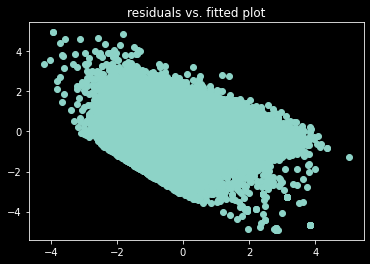

In [6]:
plt.scatter(ols.predict(), ols.resid)
plt.title("residuals vs. fitted plot")
plt.show()

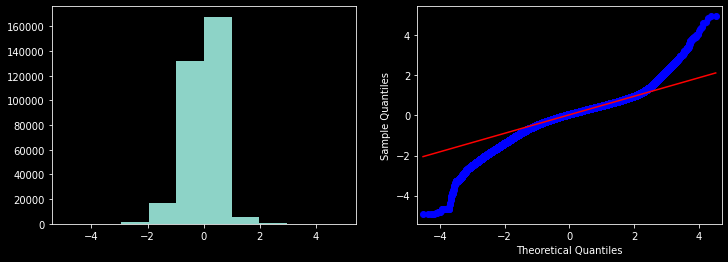

In [7]:
q_q_plot(ols.resid)

In [8]:
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.Longitude, df.Latitude))
gdf = gdf.set_crs("EPSG:4326")
gdf = gdf.to_crs("EPSG:26916")

Text(0.5, 1.0, 'Residuals')

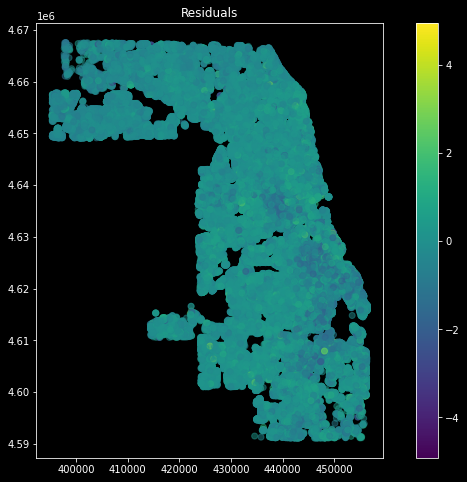

In [9]:
gdf.plot(column=ols.resid, legend=True, cmap="viridis",
         alpha=0.5, figsize=(12,8))
plt.title("Residuals")

In [10]:
#w = DistanceBand.from_dataframe(gdf,threshold=800) # needed k large enough that it was connected
w = KNN.from_dataframe(gdf,k=256)
w.transform = 'R'

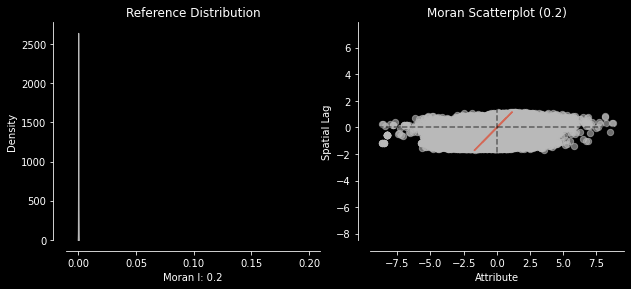

In [11]:
ols_moran = Moran(ols.resid, w, permutations=199)
plot_moran(ols_moran, zstandard=True, figsize=(10,4))
plt.show()